<a href="https://www.kaggle.com/code/averma111/lightning-timeseries?scriptVersionId=136599256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [237]:
%%capture 
!pip install torchmetrics

In [238]:
%%capture 
!pip install lightning

In [239]:
import numpy as np
import pandas as pd
import copy
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC
from pytorch_lightning import LightningModule, Trainer ,LightningDataModule
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.profilers import SimpleProfiler
import lightning as L

from torchmetrics.regression import SymmetricMeanAbsolutePercentageError


import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [240]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [241]:
train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['quarter'] = train['date'].dt.quarter
train['weekday'] = train['date'].dt.weekday
train.head()


,id,date,country,store,product,num_sold,year,month,day,quarter,weekday
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,1,6
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,1,6
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,1,6
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,1,6
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,1,6


In [242]:
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
test['date'] = pd.to_datetime(test['date'], errors='coerce')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['quarter'] = test['date'].dt.quarter
test['weekday'] = test['date'].dt.weekday
test.head()

,id,date,country,store,product,year,month,day,quarter,weekday
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,1,5
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,1,5
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,1,5
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,1,5
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,1,5


In [243]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
 6   year      136950 non-null  int64         
 7   month     136950 non-null  int64         
 8   day       136950 non-null  int64         
 9   quarter   136950 non-null  int64         
 10  weekday   136950 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 11.5+ MB


In [244]:
product_by_sold=train.groupby(['product'])['num_sold'].sum().reset_index()
product_by_sold

,product,num_sold
0,Using LLMs to Improve Your Coding,6069281
1,Using LLMs to Train More LLMs,5993975
2,Using LLMs to Win Friends and Influence People,932564
3,Using LLMs to Win More Kaggle Competitions,5068313
4,Using LLMs to Write Better,4604192


In [245]:
store_by_sold=train.groupby(['store'])['num_sold'].sum().reset_index()
store_by_sold

,store,num_sold
0,Kagglazon,15661335
1,Kaggle Learn,2755934
2,Kaggle Store,4251056


In [246]:
country_by_sold=train.groupby(['country'])['num_sold'].sum().reset_index()
country_by_sold

,country,num_sold
0,Argentina,1683244
1,Canada,7013114
2,Estonia,3577319
3,Japan,6013786
4,Spain,4380862


In [247]:
date_by_sold=train.groupby(['date'])['num_sold'].sum().reset_index()
date_by_sold

,date,num_sold
0,2017-01-01,20086
1,2017-01-02,15563
2,2017-01-03,15039
3,2017-01-04,14516
4,2017-01-05,14083
...,...,...
1821,2021-12-27,16724
1822,2021-12-28,18507
1823,2021-12-29,20110
1824,2021-12-30,20156


In [248]:
year_by_sold=train.groupby(['year'])['num_sold'].sum().reset_index()
year_by_sold

,year,num_sold
0,2017,4451213
1,2018,4723963
2,2019,4522172
3,2020,4086498
4,2021,4884479


In [249]:
month_by_sold=train.groupby(['month'])['num_sold'].sum().reset_index()
month_by_sold

,month,num_sold
0,1,2042783
1,2,1782267
2,3,1905982
3,4,1764963
4,5,1866246
5,6,1779787
6,7,1858402
7,8,1867996
8,9,1833097
9,10,1924133


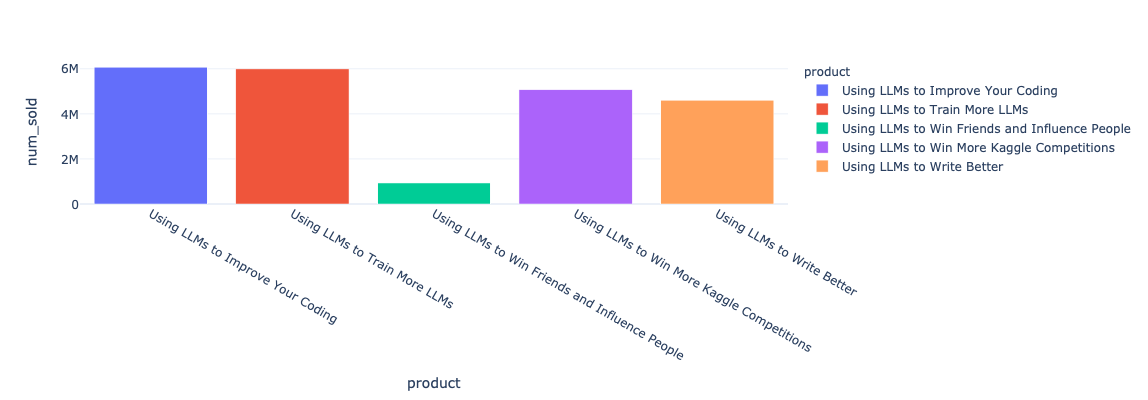

In [250]:
fig = px.bar(product_by_sold,x='product',y='num_sold',width=800, height=400,color='product')
fig.show()

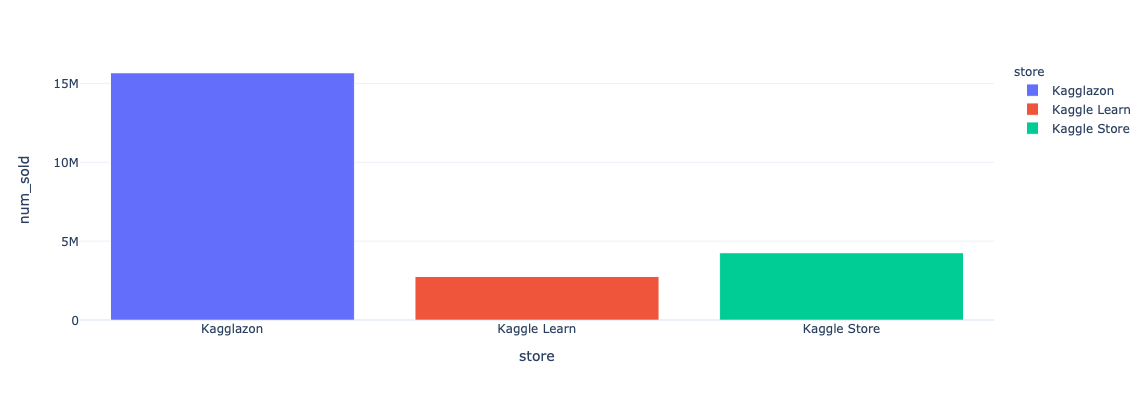

In [251]:
fig = px.bar(store_by_sold,x='store',y='num_sold',width=800, height=400,color = 'store')
fig.show()

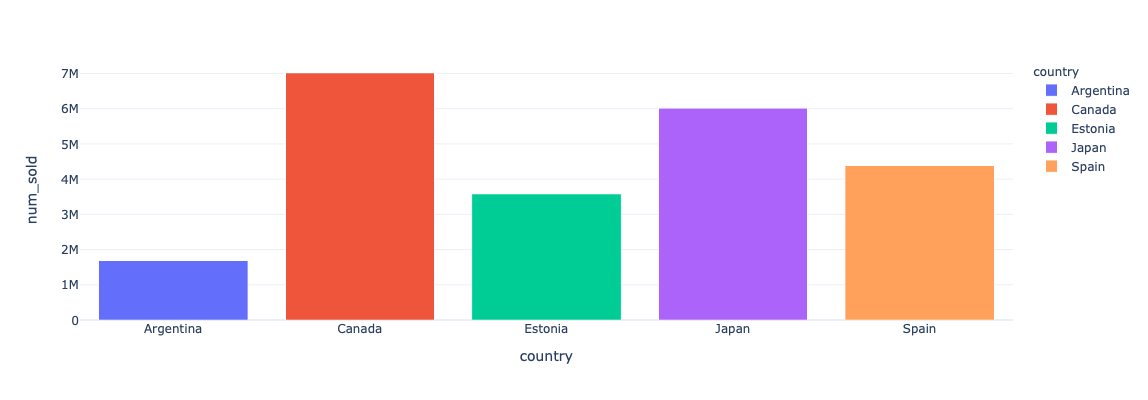

In [252]:
fig = px.bar(country_by_sold,x='country',y='num_sold',width=800, height=400,color='country')
fig.show()

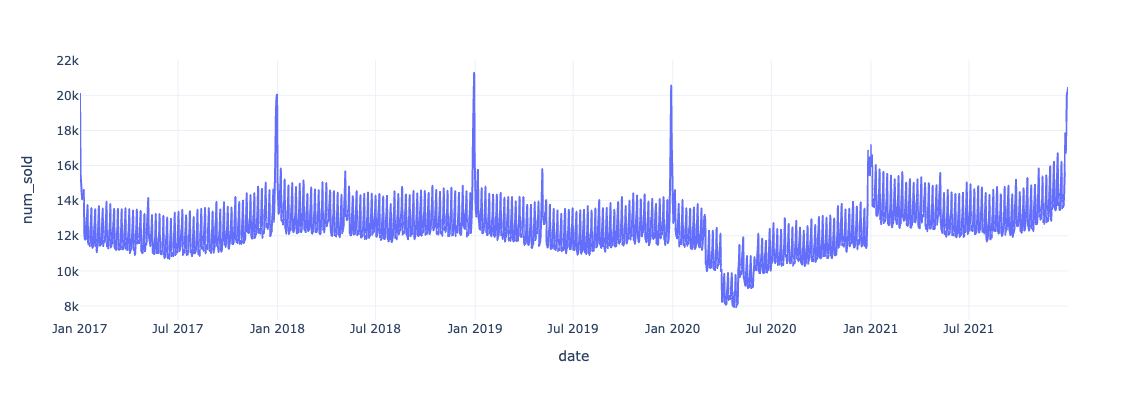

In [253]:
fig = px.line(date_by_sold,x='date',y='num_sold',width=800, height=400)
fig.show()

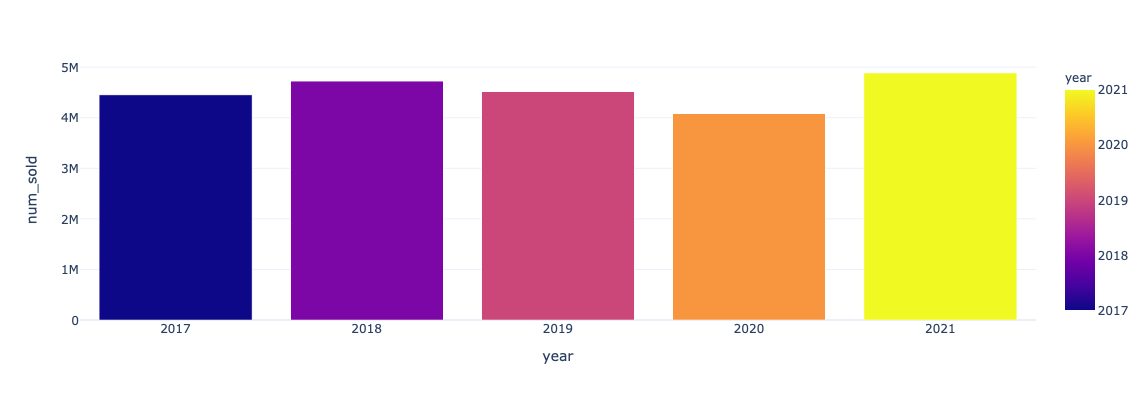

In [254]:
fig = px.bar(year_by_sold,x='year',y='num_sold',width=800, height=400,color='year')
fig.show()

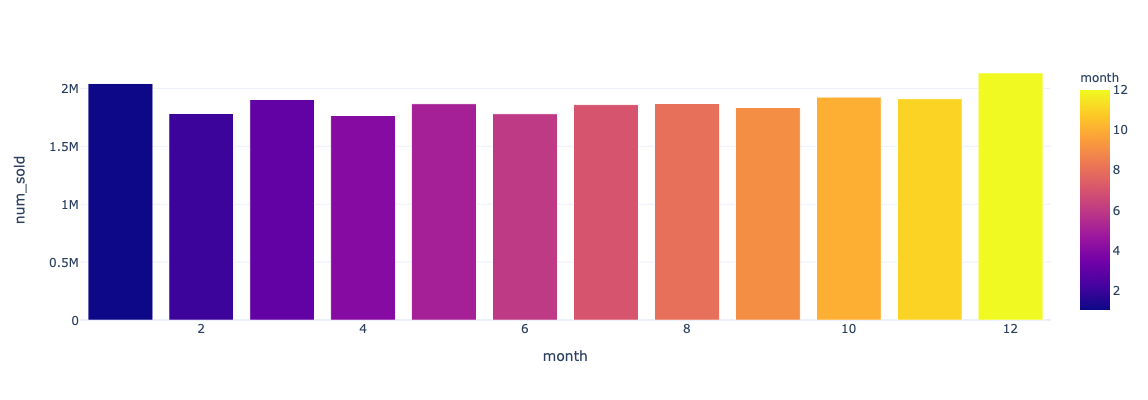

In [255]:
fig = px.bar(month_by_sold,x='month',y='num_sold',width=800, height=400,color='month')
fig.show()

In [256]:
class Config:
    num_of_label = 1
    batch_size = 32
    learning_rate = 0.0001
    random_state =42
    accelerator='cpu'
    devices=1
    precision=16
    max_epochs=10
    mode="min"
    patience=10

In [257]:
class Preprocessing():
    
    def set_label_encoder(self,df):
        encoder = LabelEncoder()
        df['store'] = encoder.fit_transform(df['store'])
        df['country'] = encoder.fit_transform(df['country'])
        df['product'] = encoder.fit_transform(df['product'])
        return df


preprocess = Preprocessing()
train = preprocess.set_label_encoder(train)

In [258]:
class ForecastingCustomData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [259]:
class PrepareData(LightningDataModule):
    
    def __init__(self,train,labels):
        self.train = train
        self.labels = labels
        self.scaler = StandardScaler()
    
    def setup(self, stage=None):
        
        if stage == "fit":
            
            self.X_train,self.X_val,self.y_train,self.y_val=train_test_split(self.train, 
                                                                             self.labels,shuffle=True,
                                                                             random_state=config.random_state)
            self.X_train_scaled=self.scaler.fit_transform(self.X_train)
            self.X_val_scaled=self.scaler.fit_transform(self.X_val)
            #print(self.X_train.shape,self.X_val.shape,self.y_train.shape,self.y_val.shape)
            self.X_data = torch.tensor(self.X_train_scaled,dtype=torch.float32)
            self.y_data = torch.tensor(self.y_train.values,dtype=torch.float32)
            self.X_val = torch.tensor(self.X_val_scaled,dtype=torch.float32)
            self.y_val = torch.tensor(self.y_val.values,dtype=torch.float32)
            
            self.train_data = ForecastingCustomData(self.X_data,self.y_data)
            self.val_data = ForecastingCustomData(self.X_val,self.y_val)
    
        if stage == "test":
            self.X_test=self.scaler.fit_transform(test)
            self.X_data_test = torch.tensor(self.X_test,dtype=torch.float32)
            self.test_data = ForecastingCustomDataTest(self.X_data_test)
                
    

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

In [260]:
class ForecastingLight(LightningModule):
    
    def __init__(self,input_features,output_features,learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.input_features = input_features
        self.output_features = output_features
        
        self.network = torch.nn.Sequential(
        torch.nn.Linear(self.input_features,16),
        torch.nn.ReLU(),
        torch.nn.Linear(16,8),    
        torch.nn.ReLU(),
        torch.nn.Linear(8,self.output_features)
                                                )
        
    def forward(self,inputs):
        return self.network(inputs)
    
    
        
    def __smape(self,outputs, labels):
        smape = SymmetricMeanAbsolutePercentageError()
        return smape(outputs,labels )

            
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("loss", loss)
        #return {'Training_Loss':loss}

              
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("loss", loss)
        #return {'Validation_Loss':loss}
    

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,momentum=0.9)
        return optimizer

In [261]:
X = train.copy()
y = train['num_sold']
X.drop(columns=['id','date','num_sold'],axis=1,inplace=True)


In [262]:
config = Config()
data_module  = PrepareData(X,y)
data_module.setup('fit')
model = ForecastingLight(8,1,config.learning_rate)

In [263]:
early_stopping = EarlyStopping(monitor="Validation_Loss", mode=config.mode, patience=config.patience)
logger = TensorBoardLogger("/kaggle/working/lightning_logs", name="ForecastLogging")
profiler = SimpleProfiler()
trainer = Trainer(accelerator=config.accelerator, 
                  devices=config.devices,
                  max_epochs=config.max_epochs,
                  callbacks=[TQDMProgressBar(refresh_rate=10)],
                  logger=logger)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [264]:
trainer.fit(model,data_module.train_dataloader(),data_module.val_dataloader()) 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


In [279]:
class PrepareDataTest(LightningDataModule):
    
    def __init__(self,test):
        self.test = test
        self.scaler = StandardScaler()
        
    def setup(self, stage=None):
        if stage == "test":
            self.X_test_scaled=self.scaler.fit_transform(self.test)
            self.X_data_test = torch.tensor(self.X_test_scaled,dtype=torch.float32)
            self.test_data = ForecastingCustomDataTest(self.X_data_test)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)
    

In [280]:
class ForecastingCustomDataTest(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
            return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [281]:
test = preprocess.set_label_encoder(test)
X_test = test[['country','store','product','year','month','day','quarter','weekday']]
X_test.head()

,country,store,product,year,month,day,quarter,weekday
0,0,1,0,2022,1,1,1,5
1,0,1,1,2022,1,1,1,5
2,0,1,2,2022,1,1,1,5
3,0,1,3,2022,1,1,1,5
4,0,1,4,2022,1,1,1,5


In [282]:
data_module_test=PrepareDataTest(X_test)
data_module_test.setup('test')

In [285]:
predictions=trainer.predict(model,data_module_test.test_dataloader())
predictions = torch.concat(predictions)

Predicting: 0it [00:00, ?it/s]

In [287]:
class Submit:
    
    def submit_predictions(self):        
        df_submit = pd.DataFrame(data={'id': test['id'],'num_sold':[a.squeeze().tolist() for a in predictions]})
        df_submit.to_csv('submission.csv',index=False)
        print('Submission Completed!!')
        return df_submit
        
        
submit = Submit()
df_submit=submit.submit_predictions()

Submission Completed!!


In [288]:
df_submit

,id,num_sold
0,136950,-0.136970
1,136951,-0.165332
2,136952,-0.183466
3,136953,-0.201601
4,136954,-0.221055
...,...,...
27370,164320,-0.435832
27371,164321,-0.405079
27372,164322,-0.363210
27373,164323,-0.321341
